In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

digits = load_digits()
data = scale(digits.data)
X = data
y = digits.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [43]:
# bagging wth KNN
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.7, max_features=0.7)
scores = cross_val_score(bagging, X_train, y_train)
mean = scores.mean()
print(scores)
print(mean)

bagging.fit(X_train, y_train)
bagging.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0.95544554 0.9675     0.95739348]
0.9601130094212428


0.9747474747474747

In [33]:
# random forests
from sklearn.ensemble import RandomForestClassifier
   
clf = RandomForestClassifier(n_estimators=500)
scores = cross_val_score(clf, X_train, y_train)
print(scores)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0.98024691 0.97256858 0.97481108]


0.9713804713804713

In [40]:
# extremely randomized trees (ExtraTrees) - randomizes the discrimination threshold
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_train, y_train)
print(scores)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0.98271605 0.98254364 0.98236776]


0.9781144781144782

In [ ]:
# Boosting

In [185]:
# Adaboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd

ds = pd.read_csv('heart_disease_weka_dataset.csv')
X = ds.drop(['num'], axis=1).values
y = ds['num'].values # actual labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

n_estimators = 4 # when using SAMME.R, the reaches optimal much faster, and thus n_estimator used here is quite low
learning_rate = .8

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)

scores = cross_val_score(ada_discrete, X_train, y_train, cv=3)
print(scores)

ada_discrete.fit(X_train, y_train)
ada_discrete.score(X_test, y_test)

[0.85074627 0.78787879 0.86153846]


0.8282828282828283

In [186]:
# finding the optimal no of trees
learning_rate = .8
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
train_scores = []
test_scores = []

for i in range(40):
    ada_discrete = AdaBoostClassifier(
       base_estimator=dt_stump,
       learning_rate=learning_rate,
       n_estimators= i * 10 + 1,
       algorithm="SAMME"
    )

    scores = cross_val_score(ada_discrete, X_train, y_train, cv=3)
    train_scores.append(scores.mean())

    ada_discrete.fit(X_train, y_train)
    test_scores.append(ada_discrete.score(X_test, y_test))

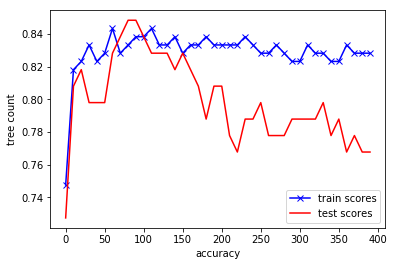

In [161]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.array(range(40)) * 10, train_scores, 'bx-', label='train scores')
plt.plot(np.array(range(40)) * 10, test_scores, 'r', label='test scores')
plt.xlabel('accuracy')
plt.ylabel('tree count')
plt.legend()
# levels off around 50-100 using SAMME with LR=0.8

In [1]:
# XGBoost
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('dermatology.data', header=None)
df.iloc[:,33] = np.where(df.iloc[:,33] == '?', 0, df.iloc[:,33]) # age column, some missing
df.iloc[:,33] = pd.to_numeric(df.iloc[:,33])
df.iloc[:,34] -= 1 # label column, from 1-6, change to 0-5
row, col = df.shape

data = df.values
X = data[:, :-1]
y = data[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [2]:
import xgboost as xgb
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

params = {}
params['objective'] = 'multi:softmax' # predict class
params['eta'] = 0.1 # rate of decreasing learning rate
params['nthread'] = 4
params['num_class'] = 6

watchlist = [(xg_train,'train'), (xg_test, 'test')] # for monitoring
num_round = 5 # rounds of gradient boosting performed
bst = xgb.train(params, xg_train, num_round, watchlist)

pred = bst.predict(xg_test)
error = sum(int(pred[i]) != y_test[i] for i in range(len(y_test))) / float(len(y_test)) 
print(f'predict class, classification error={error}')

params['objective'] = 'multi:softprob' # predict proba
bst = xgb.train(params, xg_train, num_round, watchlist)

yprob = bst.predict(xg_test).reshape(y_test.shape[0], 6)
ylabel = np.argmax(yprob, axis=1)
error = sum(int(ylabel[i]) != y_test[i] for i in range(len(y_test))) / float(len(y_test)) 
print(f'predict proba, classification error={error}')

[0]	train-merror:0.020408	test-merror:0.033058
[1]	train-merror:0.020408	test-merror:0.033058
[2]	train-merror:0.016327	test-merror:0.024793
[3]	train-merror:0.012245	test-merror:0.024793
[4]	train-merror:0.016327	test-merror:0.024793
predict class, classification error=0.024793388429752067
[0]	train-merror:0.020408	test-merror:0.033058
[1]	train-merror:0.020408	test-merror:0.033058
[2]	train-merror:0.016327	test-merror:0.024793
[3]	train-merror:0.012245	test-merror:0.024793
[4]	train-merror:0.016327	test-merror:0.024793
predict proba, classification error=0.024793388429752067


In [1]:
# stacking ensembles

# data: biomolecular, classify 'Activity' - either 0 or 1
import numpy as np
import pandas as pd
train = pd.read_csv('biomolecular_train.csv')
y = np.array(train['Activity'])
X = np.array(train.values[:,1:])

submission = pd.read_csv('biomolecular_test.csv')
X_submission = submission.values

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

n_folds = 10
skf = StratifiedKFold(n_folds)

clfs = [
    RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
    ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
    ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
    GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)
]

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))

for j, clf in enumerate(clfs):
    print(j, clf)
    # used to store predictions of all submission samples per fold (see more below)
    dataset_blend_test_j = np.zeros((X_submission.shape[0], n_folds))
    
    for i, (train, test) in enumerate(skf.split(X, y)):
        print("Fold", i)
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test] # y_test is not necessary here
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:,1] # prob of positive class
        
        # store the prediction for every fold, so all samples will have a prediction in the end
        dataset_blend_train[test, j] = y_pred
        
        # predict submission data every fold, then take average after loop
        dataset_blend_test_j[:,i] = clf.predict_proba(X_submission)[:,1] # prob of positive class
    dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)

# Blend results
# instead of just taking the average of the results, LogReg is used to generate a 'average' by predicting from the classifiers' predictions
clf = LogisticRegression()
clf.fit(dataset_blend_train, y)
y_submission = clf.predict_proba(dataset_blend_test)[:,1]

# stretching results to 0-1
y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())

0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
2 Extra

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
clf.score(dataset_blend_train, y)

0.8091175686483605